<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo03-optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing Optimization Methods

Recall our three step framework for understanding deep learning:

1. **Model**

2. **Loss**

3. **Optimizer**

The optimizer performs the crucial purpose of improving the model by decreasing the loss function. In this demo, we'll dive into different methods for optimization. The different methods we'll explore are:

* Gradient Descent
* Newton's Method (second-order derivative)
* Momentum
* ADAM

Our goal will be to visualize how each method works and discuss the advantages and disadvantages of each.

As always, we'll import some helpful libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torch

%matplotlib inline

The main purpose today is to have a high level discussion of different optimization methods. The code is simply to visualize different loss functions and how optimization methods perform.

That is to say, please don't worry about understanding any of the code.

### Fancy Plotting Code :)

In [ ]:
class QuadFunc:
  def __init__(self, a, b, c, d, e):
    self.a = a
    self.b = b
    self.c = c
    self.d = d
    self.e = e

  def getParams(self, x, y):
    if y is None:
      y = x[1]
      x = x[0]
    return x,y

  def __call__(self, x, y=None):
    x,y = self.getParams(x,y)
    return 0.5 * (self.a*x**2 + self.b*y**2) + self.c * x * y + self.d * x + self.e * y

  def grad(self, x, y=None):
    #df/dx = ax + cy + d
    #df/dy = by + cx + e
    x,y = self.getParams(x,y)
    return torch.tensor([self.a * x + self.c * y + self.d, self.b * y + self.c * x + self.e])

  def hess(self, x, y=None):
    #d2f/dx2 = a
    #d2f/dy2 = b
    #d2f/dxdy = c
    #d2f/dydx = c
    x, y = self.getParams(x,y)
    return torch.tensor([[self.a, self.c], [self.c, self.b]])

class GradientDescent:
    def __init__(self, lr=1, b1=0.9, b2=0.999):
        # b1 -> Momentum
        # b2 -> ADAM
        # ADAM Paper -> https://arxiv.org/abs/1412.6980
        self.lr = lr # learning rate
        self.b1 = b1 # grad aggregation param (for Momentum)
        self.b2 = b2 # grad^2 aggregation param (for ADAM)

        self.v = 0 # grad aggregation param
        self.w = 0 # grad^2 aggregation param
        self.t = 0

        self.eps = 1e-9

    def __call__(self, grad,hess):

        self.t += 1


        # aggregation
        self.v = self.b1*self.v + (1-self.b1)*grad
        self.w = self.b2*self.w + (1-self.b2)*grad**2

        # bias correction
        vcorr = self.v/(1-self.b1**self.t)
        wcorr = self.w/(1-self.b2**self.t) if self.b2 != 0 else 1

        return -1*self.lr*vcorr/(wcorr**0.5 + self.eps)

class Newtons:
    # https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization
    def __init__(self, lr=1):
        self.lr = lr

    def __call__(self,grad,hess):
        return -1*self.lr*torch.matmul(torch.inverse(hess), grad)

def runOptim(init,optim,func,steps):

    curpos = init # current position
    path = [curpos]


    for _ in range(steps):

        grad = func.grad(curpos)
        hess = func.hess(curpos)

        dx = optim(grad,hess)
        curpos = curpos + dx
        path.append(curpos)

    return path


def showPath(func,init,paths,labels,colors,levels):

    x = torch.arange(-10,10,0.05)
    y = torch.arange(-10,10,0.05)

    # create meshgrid
    xx, yy = torch.meshgrid(x,y)
    zz = func(xx,yy)

    # create contour
    fig, ax = plt.subplots(1,1,figsize=(16,10))
    cp = ax.contourf(xx,yy,zz,levels)
    fig.colorbar(cp)

    # mark initial point
    ax.plot(init[0],init[1],'ro')
    ax.text(init[0]+0.5,init[1]+0.5,'Intial Point',color='white')

    # Plot paths
    for pnum in range(len(paths)):
        for i in range(len(paths[pnum])-1):
            curpos = paths[pnum][i]
            d = paths[pnum][i+1] - curpos
            ax.arrow(curpos[0],curpos[1],d[0],d[1],color=colors[pnum],head_width=0.2)
            ax.text(curpos[0]+d[0],curpos[1]+d[1],str(i),color='white')

    # Add legend
    legends = []
    for col in colors:
        legends.append(mpatches.Patch(color=col))
    ax.legend(legends,labels)


## Gradient Descent

Because we can't *really* visualize functions in more than two dimensions, we'll be using loss functions defined on two parameters $x_1$ and $x_2$.

In general, the form of the loss function we'll consider is

$$
L(x_1, x_2) = ax_1^2 + bx_2^2 + cx_1 x_2 + dx_1 + ex_2.
$$

This is a polynomial with degree 2. By changing the coefficients, we can get functions that are more or less well-behaved.

The simplest algorithm that we could use is gradient descent. And we've seen this before! Recall that the updated parameters $x_1^{(t)}$ and $x_2^{(t)}$ at the $t$th step of the algorithm are given by

$$
x_1^{(t)} = x_1^{(t-1)} - \alpha \frac{dL(x_1^{(t-1)},x_2^{(t-1)} )}{dx_1}
$$

and

$$
x_2^{(t)} = x_2^{(t-1)} - \alpha \frac{dLx_1^{(t-1)}, x_2^{(t-1)})}{dx_2}
$$

where $\alpha$ is a learning rate.
In words, the next parameter is the prior parameter minus a learning rate times the derivative.

Instead of writing the update in terms of scalar values, we can talk about the *vector* of weights $\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$.
Then

$$
\mathbf{x}^{(t)} = \mathbf{x}^{(t-1)} - \alpha \nabla_\mathbf{x} f(\mathbf{x}).
$$

Since we'll be working in high dimensions, it's worth convincing yourself that these two ways of writing the update are equivalent. To do so, recall that

$$
\nabla_\mathbf{x} f(\mathbf{x})
= \begin{bmatrix} \frac{dL(x_1,x_2)}{dx_1} \\
\frac{dL(x_1,x_2 )}{dx_2} \end{bmatrix}.
$$

Let's choose a simple loss function
$$L(x_1, x_2) = x_1^2 + x_2^2$$
and visualize how gradient descent performs on it.

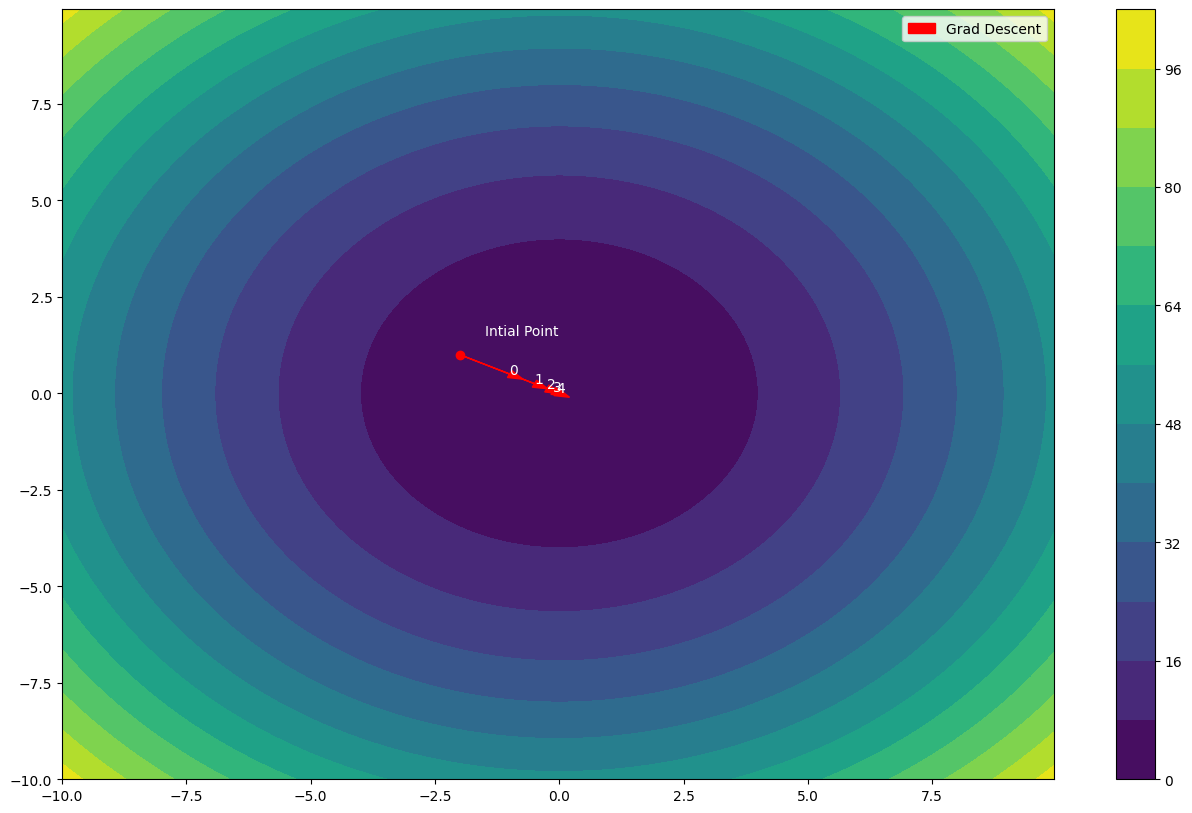

In [40]:
L = QuadFunc(a=1.0, b=1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0, 1.0])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0)
steps = 5
path = runOptim(init, regGD, L, steps)
showPath(L, init, [path], ['Grad Descent'], ['r'], levels=15)

Gradient descent does very well! This is excellent. But, unfortunately, not all functions are so well behaved.

Let's try a different loss function
$$
L(x_1, x_2) = x_1^2 - x_2^2.
$$
As we increase $x_1$, the function quadratically *increases* but as we increase $x_2$, the function quadratically *decreases*.

Let's try initializing our model at $x_1 = 2$ and $x_2=0$. Something goes wrong! Gradient descent has no gradient update in $x_2$ (since it's 0) and we only find the local saddle point. A saddle point is a point that is smallest in one direction (e.g. $x_1$) but not in another direction (e.g. $x_2$).

However, if we initialize our model at a point where $x_2 \neq 0$, then we actually **do** move away from the saddle point. This example motivates the following common practice: initializing our models with randomly chosen weights so that it's less likely we get stuck at local optimum.

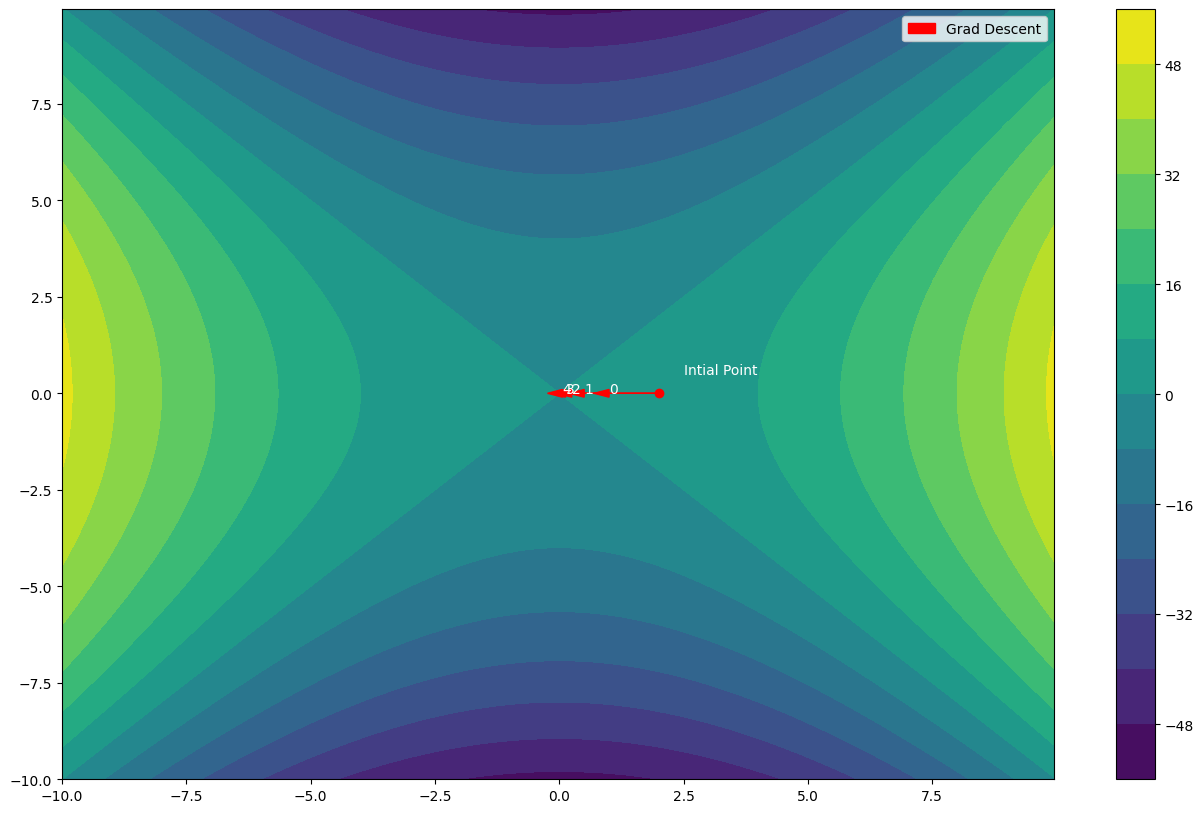

In [43]:
f = QuadFunc(a=1.0, b=-1.0, c=0., d=0., e=0.)
init = torch.tensor([2, 0])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) # turned off Momentum and ADAM
steps = 5
path = runOptim(init, regGD, f, steps)
showPath(f, init, [path], ['Grad Descent'], ['r'], levels=15)

Let's try another type of loss function like an ellipse.
The particular ellipse we'll use is

$$
L(x_1, x_2) = \frac{1}{\sqrt{2}} x_1^2
- \frac{4}{5\sqrt{2}} x_2^2
+ \frac{1}{\sqrt{2}} x_1 x_2
+ \frac{1}{\sqrt{2}} x_1 +
\frac{1}{\sqrt{2}} x_2.
$$
We chose this particular (weird) function because it gives a nice plot.

When we run gradient descent, we find a problem! The method oscillates back and forth, essentially wasting steps and slowing down the optimization process. If we try reducing the learning rate to something like $.5$, gradient descent no longer oscillates back and forth but it moves very slowly.

Clearly, we need a better kind of optimization method.

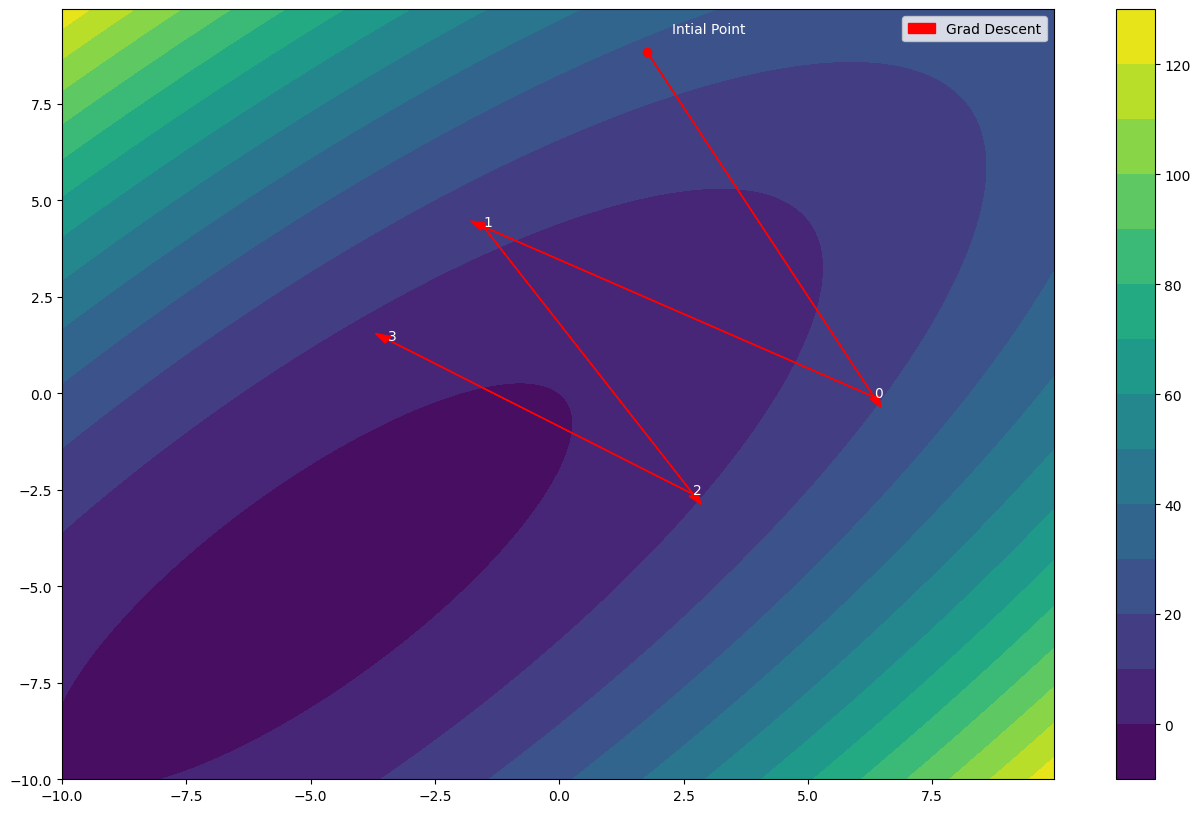

In [48]:
a = 1/torch.sqrt(torch.tensor(2.0))
L = QuadFunc(a,a,-0.8*a,a,a)

init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
steps = 4
regGD = GradientDescent(lr=1.5, b1=0, b2=0)
path = runOptim(init, regGD, L, steps)
showPath(L, init, [path], ['Grad Descent'], ['r'], 15)

## Newton's Method

One candidate for a better optimization method is Newton's Method. Instead of just the first order derivative, Newton's Method uses the second order derivative to optimize.

The update is given by

$$
\mathbf{x}^{(t)} = \mathbf{x}^{(t-1)} - \alpha \left[ \nabla^2_\mathbf{x} L(\mathbf{x}^{(t-1)}) \right]^{-1} \nabla_\mathbf{x} L(\mathbf{x}^{(t-1)}).
$$

Here, $\nabla^2_\mathbf{x} f(\mathbf{x})$ is the Hessian matrix which contains second derivatives.

$$
\nabla^2_\mathbf{x} L(\mathbf{x}) = \begin{bmatrix}
\frac{dL(\mathbf{x})}{dx_1 d x_1} & \frac{dL(\mathbf{x})}{dx_1 d x_2} \\
\frac{dL(\mathbf{x})}{dx_2 d x_1} & \frac{dL(\mathbf{x})}{dx_2 d x_2} \\
\end{bmatrix}
$$

The form of Newton's Method update can be obtained by approximating the local neighborhood of $L(\mathbf{x})$ with the first few terms of its Taylor series and then optimizing for the best update step.

It's not so important that you understand the math but it is important that you understand Newton's Method uses second order information. If we have $d$ parameters, we can compute and store the gradient in $O(d)$ time and space. But, we need $O(d^2)$ time and space to compute and store the Hessian matrix. We can see this since the Hessian contains $d^2$ entries.

What do we get for all that extra space and time?

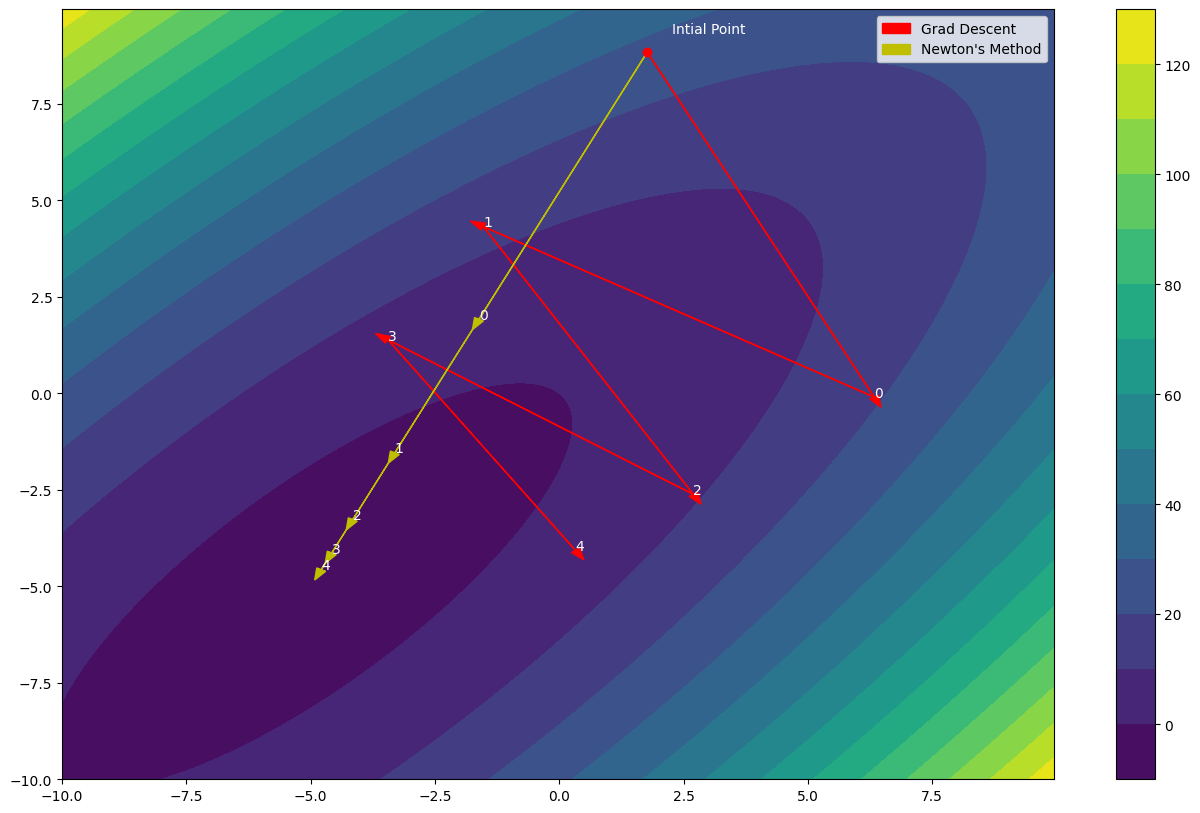

In [51]:
a = 1/torch.sqrt(torch.tensor(2.0))
ell = QuadFunc(a,a,-0.8*a,a,a)

init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
steps = 5
regGD = GradientDescent(lr=1.5, b1=0, b2=0)
newMT = Newtons(lr=0.5)
path = runOptim(init, regGD, ell, steps)
path2 = runOptim(init, newMT, ell, steps)
showPath(ell, init, [path, path2], ['Grad Descent', 'Newton\'s Method'], ['r', 'y'], 15)

Well in this case, we get the right answer very quickly!

Unfortunately, in addition to taking awhile to compute, Newton's method is attracted to saddle points. So, in the example we had before, Newton's method will converge to the saddle point. In contrast, as long as it is initialized with $x_2 \neq 0$, gradient descent will move away from the saddle point.

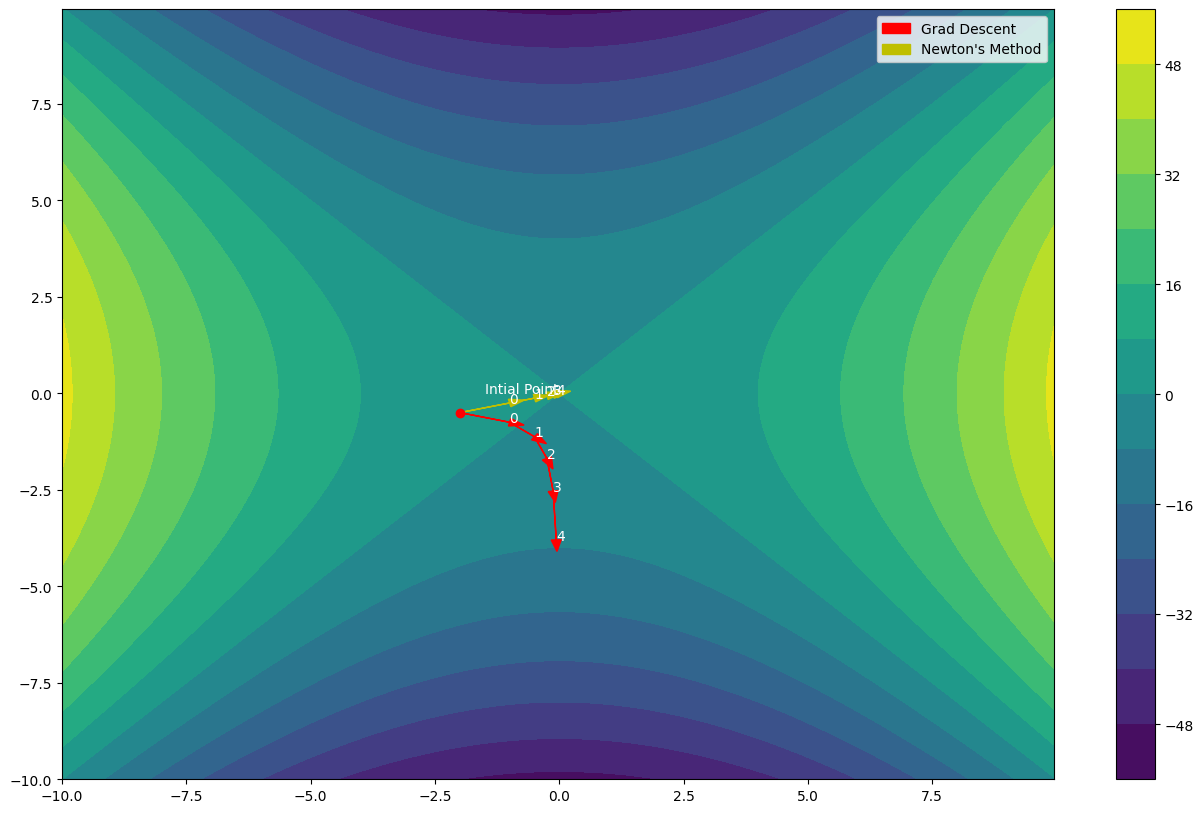

In [55]:
L = QuadFunc(a=1.0, b=-1.0, c=0., d=0., e=0.)
init = torch.tensor([-2.0, -0.5])
regGD = GradientDescent(lr = 0.5, b1=0, b2=0) # turned off Momentum and ADAM
newMT = Newtons(lr=0.5)
steps = 5
path = runOptim(init, regGD, L, steps)
path2 = runOptim(init, newMT, L, steps)
showPath(L, init, [path, path2], ['Grad Descent', 'Newton\'s Method'], ['r', 'y'], levels=15)

In order to see why Newton's method is attracted to the saddle points, we can consider the eigendecomposition of $\nabla^2_\mathbf{x}f(\mathbf{x})$. Let $V$ be the matrix of eigenvectors and $\Lambda$ be the matrix with eigenvalues on its diagonal.

Then Newton's method update is given by

$$
\mathbf{x}^{(t)} = \mathbf{x}^{(t-1)} - \alpha \left[ \nabla^2_\mathbf{x} L(\mathbf{x}^{(t-1)}) \right]^{-1} \nabla_\mathbf{x} L(\mathbf{x}^{(t-1)})
$$
$$
= \mathbf{x}^{(t-1)} - \alpha \left( V \Lambda^{-1} V^\top \right) \nabla_\mathbf{x} L(\mathbf{x}^{(t-1)}).
$$

If the eigenvalues are negative, the we'll actually be taking a step in the direction of the gradient which is the direction of steepest *ascent*. For our particular function
$L(x_1, x_2) = x_1^2 - x_2^2$, the Hessian is
$$
\nabla^2_\mathbf{x} L(\mathbf{x})
 = \begin{bmatrix}
\frac{dl(\mathbf{x})}{dx_1 d x_1} & \frac{dl(\mathbf{x})}{dx_1 d x_2} \\
\frac{dl(\mathbf{x})}{dx_2 d x_1} & \frac{dl(\mathbf{x})}{dx_2 d x_2} \\
\end{bmatrix}
= \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}.
$$

So we have a negative eigenvalue and we actually take steps to *increase* the loss function!



## Momentum

We want the advantages of Newton's method without the large time to compute and the attraction to saddle points.

One solution is to keep a *memory* of the steps we previously took. We call this approach momentum.

We maintain an update vector $\mathbf{v}$ (initialized to 0) that keeps track of the direction we move in. Then

$$
\mathbf{v}^{(t)} = \beta \mathbf{v}^{(t-1)} + \nabla_\mathbf{x} L(\mathbf{x})
$$

where $0 < \beta < 1$ is a number we use to control how much the prior directions influence the next direction.
The update is then given by

$$
\mathbf{x}^{(t)} = \mathbf{x}^{(t-1)} - \alpha \mathbf{v}^{(t-1)}
$$

Notice that if $\beta=0$, we recover gradient descent!

On our ellipse loss function, we can see how the momentum method keeps track of what we did previously so that we don't oscillate back and forth as we do with gradient descent.

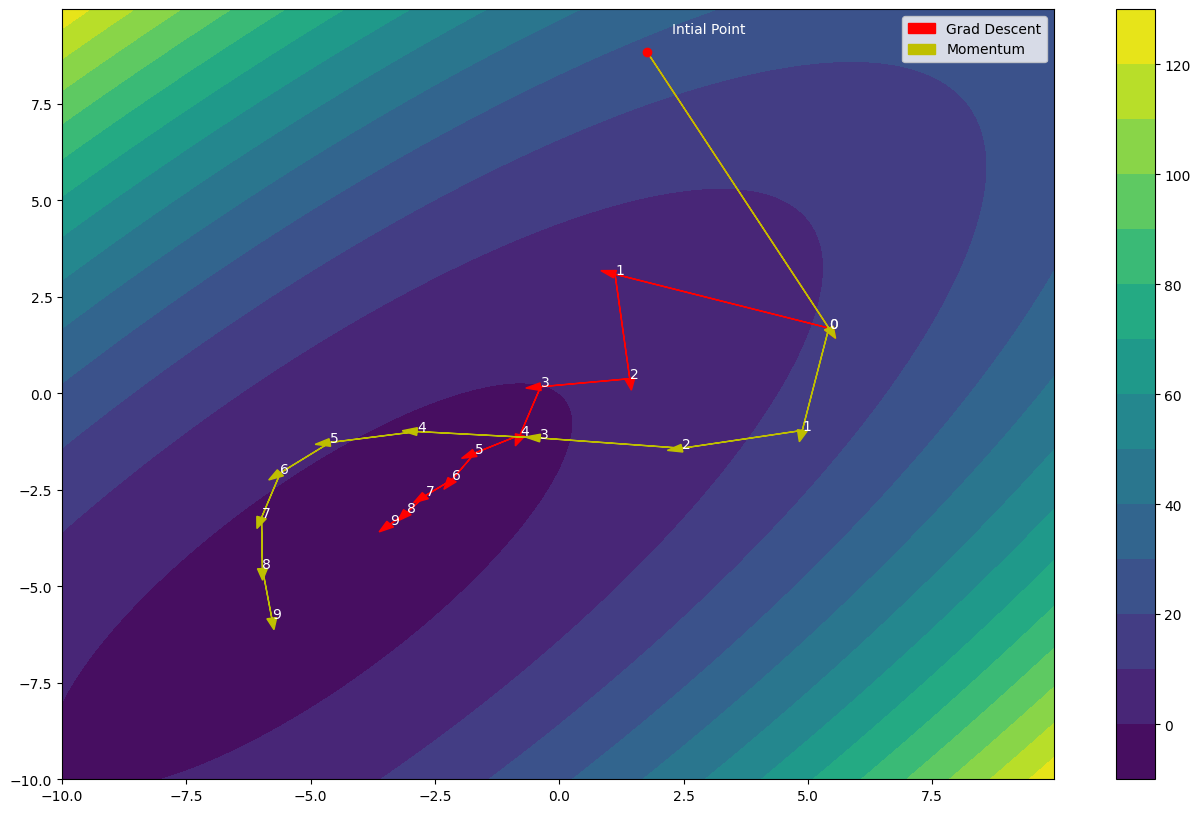

In [ ]:

a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
ell = QuadFunc(a,a,-0.8*a,a,a)
steps = 10
lr = 1.2
regGD = GradientDescent(lr,0,0) # Without Momentum
momGD = GradientDescent(lr,0.9,0) # Momentum
path1 = runOptim(init,regGD,ell,steps)
path2 = runOptim(init,momGD,ell,steps)
showPath(ell,init,[path1,path2],['Grad Descent','Momentum'],['r','y'], 15)


## ADAM

One problem we have with just momentum is that the method is quite senstive to the learning rate we choose. If the learning rate is too large, we make lots of progress in the beginning but then overshoot the optimum and waste lots of update steps circling around it (we can see this example in the figure below).

One solution is to keep track of the *magnitude* of the gradient updates. If the gradient has large magnitude, then we reduce our step size. If the gradient has small magnitude and we're not making much progress, then we increase our step size. The particular ADAM optimizer is described well in the original [paper](https://arxiv.org/pdf/1412.6980v8.pdf). Since the update description gets messy, I won't write it here.

In the figure below, we can see how it adaptively increases and decreases the step size so that the path to the optimum is more efficient.

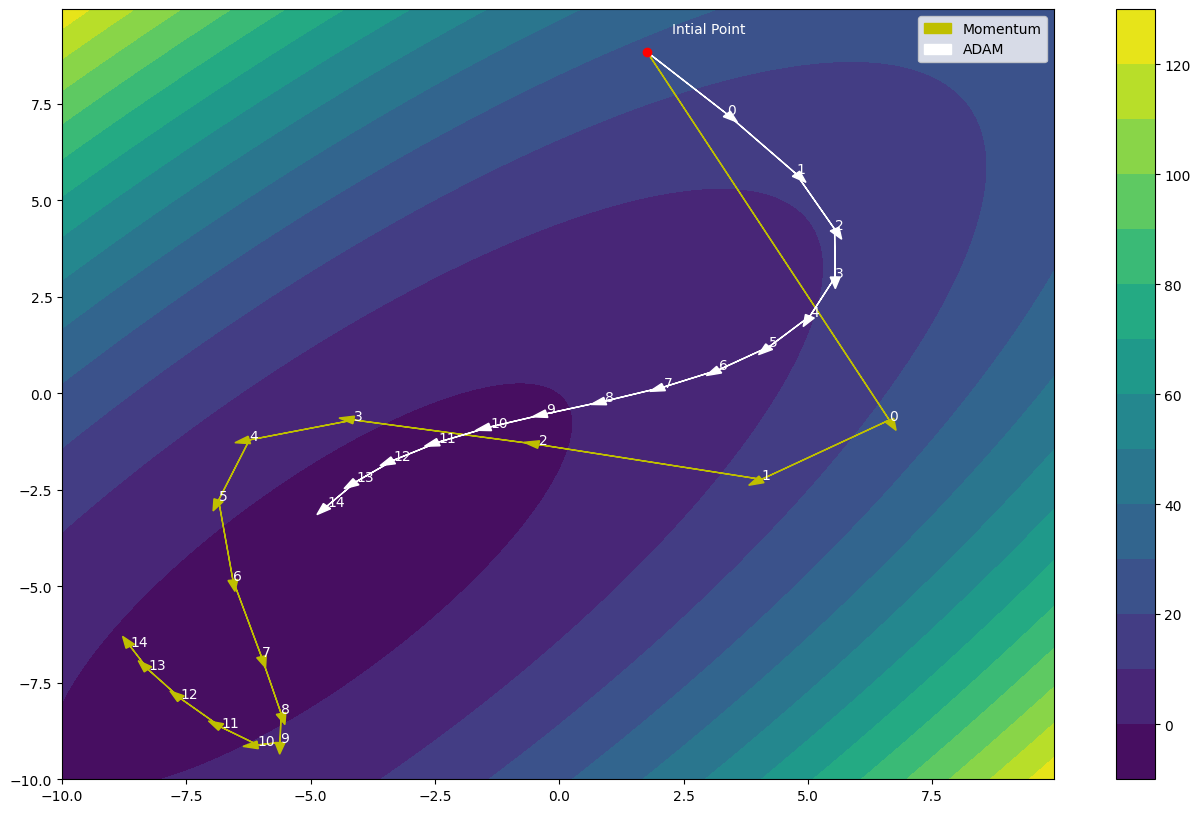

In [ ]:

a = 1/torch.sqrt(torch.tensor(2.0))
init = torch.matmul(torch.tensor([[a,a],[-a,a]]),torch.tensor([-5.0,7.5]))
L = QuadFunc(a,a,-0.8*a,a,a)
steps = 15
lr = 1.6

regGD = GradientDescent(lr,0,0)
momGD = GradientDescent(lr,0.9,0)
adamGD = GradientDescent(lr,0.9,0.999)
path1 = runOptim(init,regGD,L,steps)
path2 = runOptim(init,momGD,L,steps)
path3 = runOptim(init,adamGD,L,steps)
showPath(L,init,[path2,path3],['Momentum','ADAM'],['y','w'], 15)

Honestly, we don't know much about the right choice of optimizer. Because our functions have so many variables, we can't plot and analyze them like we did for our small loss function in this demo.

Most of the time, people try different loss functions in practice and use the one that works the best. Bonus for ones that are intuitively motivated :)

The deep learning community has generally come to agree that ADAM is a very good choice and it's quite common to use ADAM as the optimizer in the three step framework we know and love.